<center><img src="https://github.com/hse-ds/iad-applied-ds/blob/master/2021/hw/hw1/img/logo_hse.png?raw=1" width="1000"></center>

<h1><center>Прикладные задачи анализа данных</center></h1>
<h2><center>Домашнее задание 3: прогнозирование временных рядов</center></h2>

In [ ]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached etna-1.15.1-py3-none-any.whl (273 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.6/750.6 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.0/354.0 kB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 94.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.1/172.1 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 79.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import warnings
import gdown
import pandas as pd
import numpy as np
import seaborn as sns
from copy import deepcopy

warnings.filterwarnings("ignore")

В данной задаче мы будем решать одну из актуальных практических задач, с которыми, в том числе, сталкиваются разработчики ETNA - прогнозирование объема необходимой наличности в банкоматах (на примере одного устройства). Пожалуй, ни для кого не секрет, что отсутствие необходимой суммы в банкомате не делает клиента банка счастливее. В то же время, избыток заправленной в банкомат наличности приводит к упущенной выгоде - ведь, в конечном счете, эти деньги могли быть размещены в качестве краткосрочного депозита на межбанковском рынке. Для кредитной организации с обширной сетью банкоматов даже незначительное улучшение качества предсказания способно внести значительный вклад в прибыльность этой ветки бизнеса.

Мы будем использовать дневные данные реального банкомата хоть и не с российского рынка, но очень схожего с ним - турецкого. Скачаем и загрузим их:

In [ ]:
url = 'https://raw.githubusercontent.com/andrei-egorov/ml_se_seminars/master/atm_daily_cash.csv'
output = 'atm_daily_cash.csv'
gdown.download(url=url, output=output, quiet=False, fuzzy=True)

df = pd.read_csv('atm_daily_cash.csv')
df = df[4:] #лучше избавиться от нескольких пропущенных значений в начале сразу,
            #могут доставлять ненужные лишние проблемы

Downloading...
From: https://raw.githubusercontent.com/andrei-egorov/ml_se_seminars/master/atm_daily_cash.csv
To: /content/atm_daily_cash.csv
26.1kB [00:00, 16.4MB/s]                   


Взглянем на то, что представляют из себя данные:

In [ ]:
df.head()

Date   CashIn  CashOut
4  1/5/2016  20840.0  22200.0
5  1/6/2016  28460.0  18810.0
6  1/7/2016  19250.0  23210.0
7  1/8/2016  49770.0   4350.0
8  1/9/2016      NaN      NaN

В нашем распоряжении пополнения и изъятия; нас интересует нетто. Для этого будем учитывать изъятия со знаком минус, а нетто определим как сумму (такое представление пригодится нам в дальнейшем).

In [ ]:
df['CashOut'] = -df['CashOut']
df['target'] = df['CashIn'] + df['CashOut']

### Задание 1. EDA (1 балл)

Проведите разведывательный анализ данных - постройте графики, на которых можно судить о наличии тренда, сезонности и прочих зависимостей. Проанализируйте корреляции. Какие выводы вы можете сделать?

In [ ]:
# проверяем данные на наличие пропусков
df.isna().sum(axis=0)
# пропусков достаточно много

Date         0
CashIn     101
CashOut     88
target     110
dtype: int64

In [ ]:
# базовые статистики
df.describe()
# видим, что таргет значительно колеблется как в плюс, так и в минус со средним около 6000

CashIn        CashOut        target
count    1081.000000    1094.000000   1072.000000
mean    37261.618871  -30985.648995   5976.651119
std     20583.186636   18314.048275  21551.659802
min       100.000000 -111700.000000 -75190.000000
25%     21690.000000  -40375.000000  -6277.500000
50%     34980.000000  -27895.000000   5320.000000
75%     50280.000000  -18010.000000  18515.000000
max    121300.000000      -0.000000  85160.000000

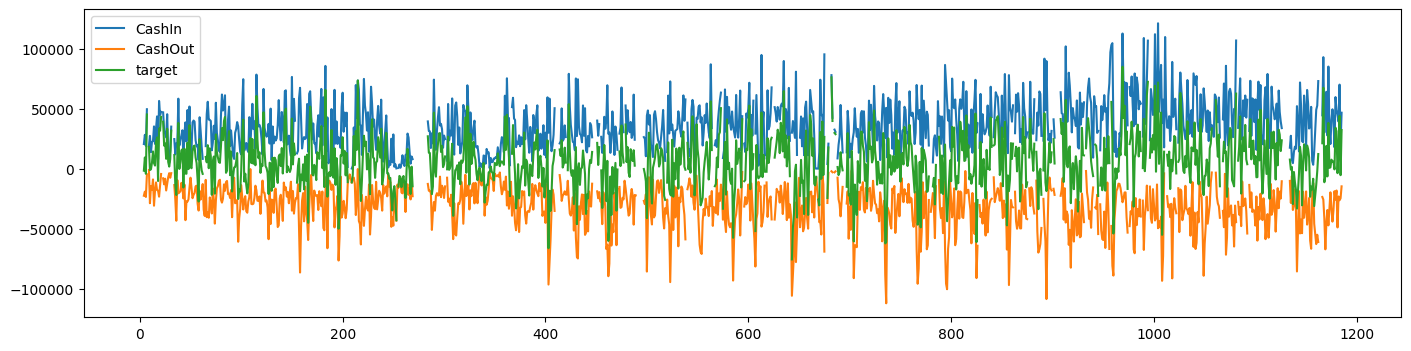

In [ ]:
df.plot(figsize=(17, 4));
# на графике видны пробелы там, где данные отсутствуют

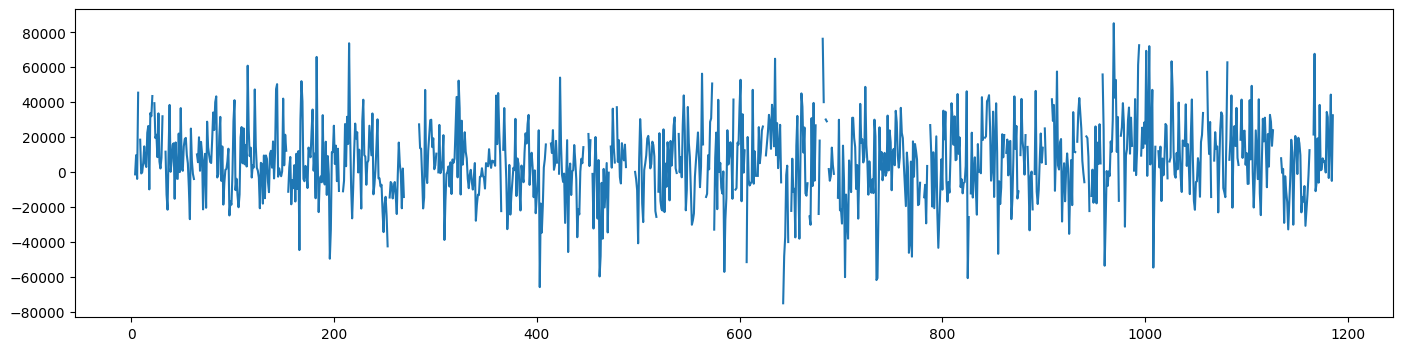

In [ ]:
# посмотрим на таргет отдельно
df['target'].plot(figsize=(17, 4));
# наблюдаем некоторые периодичные колебания (что-то вроде синусоиды)

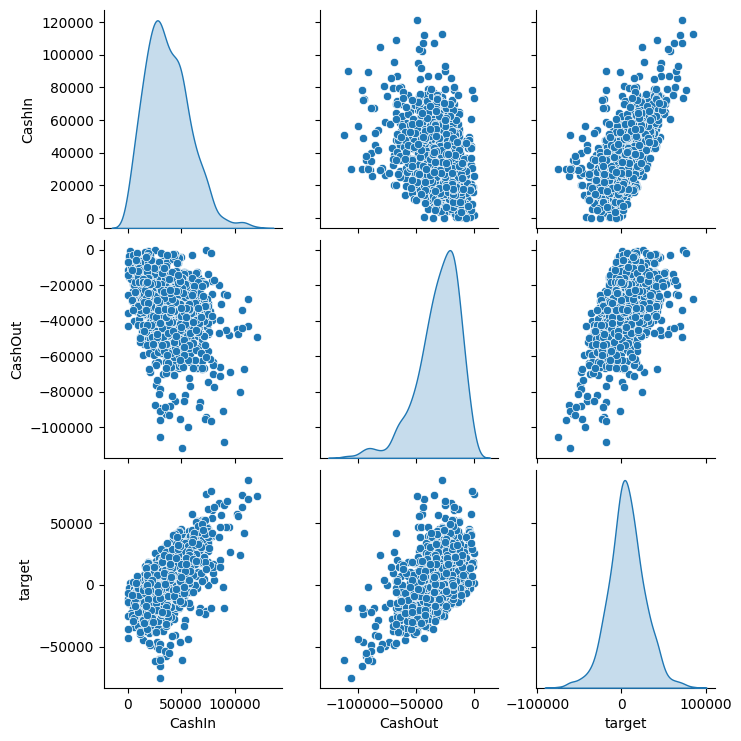

In [ ]:
# Совместные распределения рядов
sns.pairplot(df, diag_kind="kde");
# видим корреляцию между CashIn/CashOut и таргетом, но это очевидно - таргет является их суммой

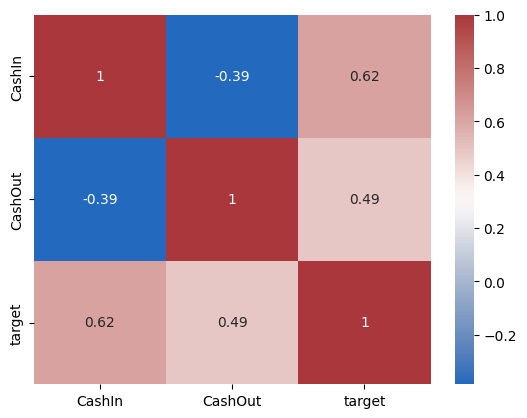

In [ ]:
# Корреляционная тепловая карта
cmap = sns.color_palette("vlag", as_cmap=True)
sns.heatmap(df.corr("pearson"), annot=True, cmap=cmap);
# CashIn и CashOut тоже коррелируют между собой

### Задание 2. Приведение в формат multi-segment (0.75 балла)

Теперь нам предстоит (в первый раз) привести данные к формату, в котором с ними будет возможно работать средствами ETNA. Вначале мы будем рассматривать и предсказывать наши данные как мульти-сегментные. Чтобы привести данные в соответствующий формат, вам пригодится функция `pd.melt`. На выходе у нас должен получиться объект `TSDataset`. Поскольку мы будем смотреть на данные не только в этом разрезе, лучше не менять исходный датафрейм и работать с копией.

In [ ]:
from etna.datasets import TSDataset

In [ ]:
df_copy = df.copy()
df_copy = df_copy.rename(columns={'Date':'timestamp'})
df_melt = pd.melt(df_copy, id_vars=['timestamp'])
df_melt = df_melt.rename(columns={'variable':'segment', 'value':'target'})
df_melt

timestamp segment   target
0      1/5/2016  CashIn  20840.0
1      1/6/2016  CashIn  28460.0
2      1/7/2016  CashIn  19250.0
3      1/8/2016  CashIn  49770.0
4      1/9/2016  CashIn      NaN
...         ...     ...      ...
3541  3/27/2019  target  -3440.0
3542  3/28/2019  target  16640.0
3543  3/29/2019  target  44310.0
3544  3/30/2019  target  -5100.0
3545  3/31/2019  target  32470.0

[3546 rows x 3 columns]

In [ ]:
df_target = TSDataset.to_dataset(df=df_melt[["target", "segment", "timestamp"]])
df_target.dropna(inplace=True)
df_target

segment      CashIn  CashOut   target
feature      target   target   target
timestamp                            
2016-01-05  20840.0 -22200.0  -1360.0
2016-01-06  28460.0 -18810.0   9650.0
2016-01-07  19250.0 -23210.0  -3960.0
2016-01-08  49770.0  -4350.0  45420.0
2016-01-10  19260.0   -760.0  18500.0
...             ...      ...      ...
2019-03-27  45160.0 -48600.0  -3440.0
2019-03-28  39480.0 -22840.0  16640.0
2019-03-29  70260.0 -25950.0  44310.0
2019-03-30  19250.0 -24350.0  -5100.0
2019-03-31  46870.0 -14400.0  32470.0

[1072 rows x 3 columns]

In [ ]:
ts = TSDataset(df_target, freq="D")
ts.info()

<class 'etna.datasets.TSDataset'>
num_segments: 3
num_exogs: 0
num_regressors: 0
num_known_future: 0
freq: D
         start_timestamp end_timestamp  length  num_missing
segments                                                   
CashIn        2016-01-05    2019-03-31    1182          110
CashOut       2016-01-05    2019-03-31    1182          110
target        2016-01-05    2019-03-31    1182          110


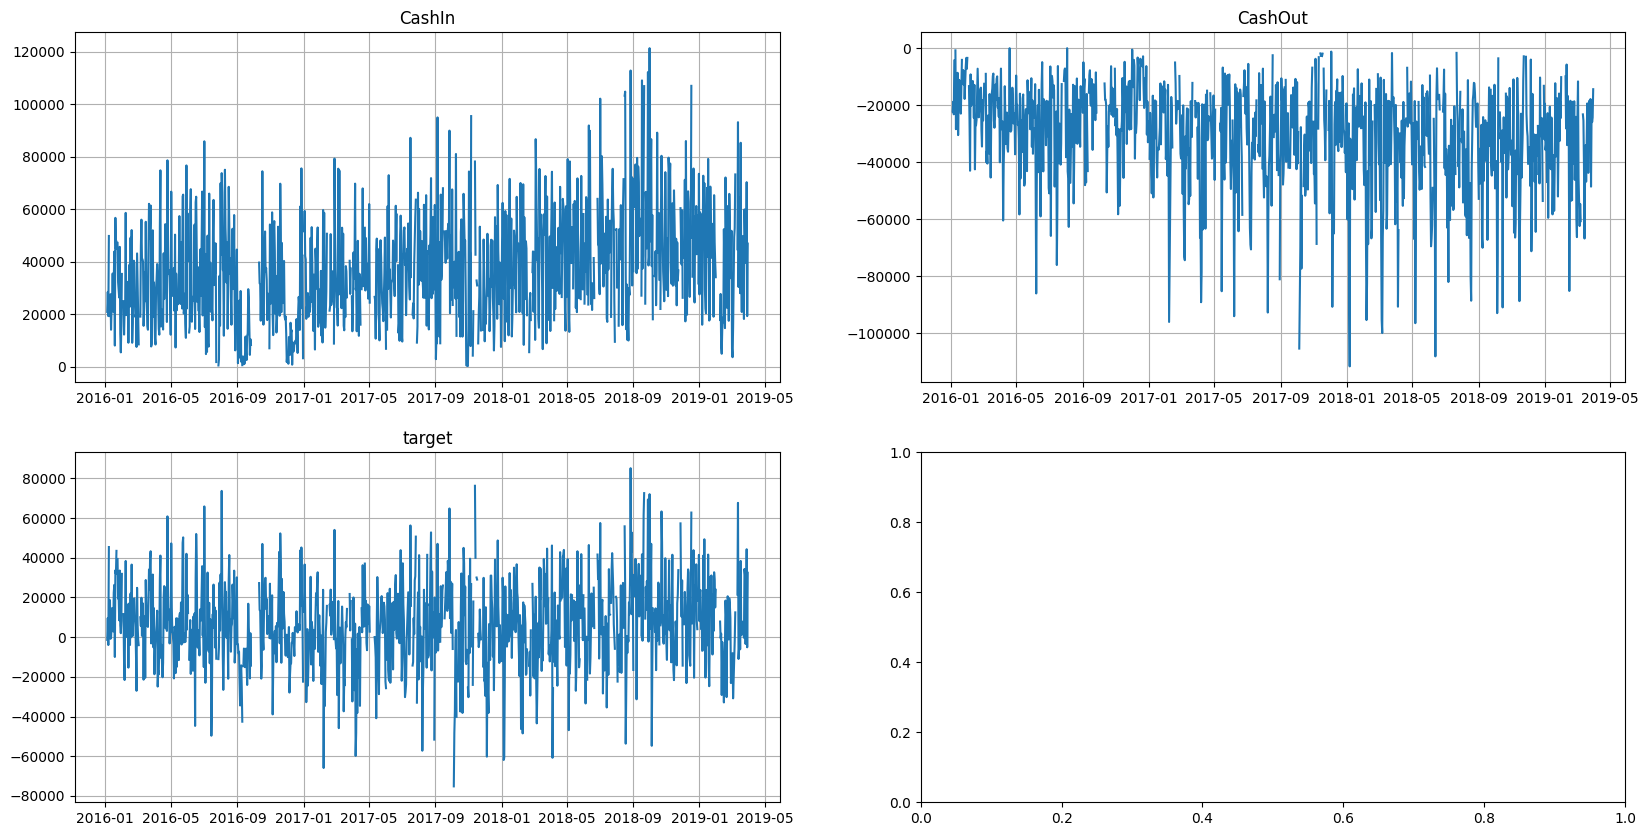

In [ ]:
ts.plot()

### Задание 3. Работа с пропущенными значениями и аутлаерами (1 балл)

Проанализируйте, есть ли в данных пропущенные значения, и подберите оптимальный метод их заполнения средствами ETNA. Какие методы вы выберете и почему? Совет: возможно, лучше сохранить заполненные данные в отдельный объект, поскольку некоторые модели заполняют пропуски встроенными методами, и подача на вход "сырых" данных (на языке временных рядов это данные с нерегулярными интервалами) может принести лучший результат.

Импорты всех необходимых компонент произведите самостоятельно.

In [ ]:
ts.isnull().sum(axis=0)

segment  feature
CashIn   target     110
CashOut  target     110
target   target     110
dtype: int64

Проверьте ряды на наличие аутлаеров, и очистите их соответствующим образом. Обоснуйте выбор.

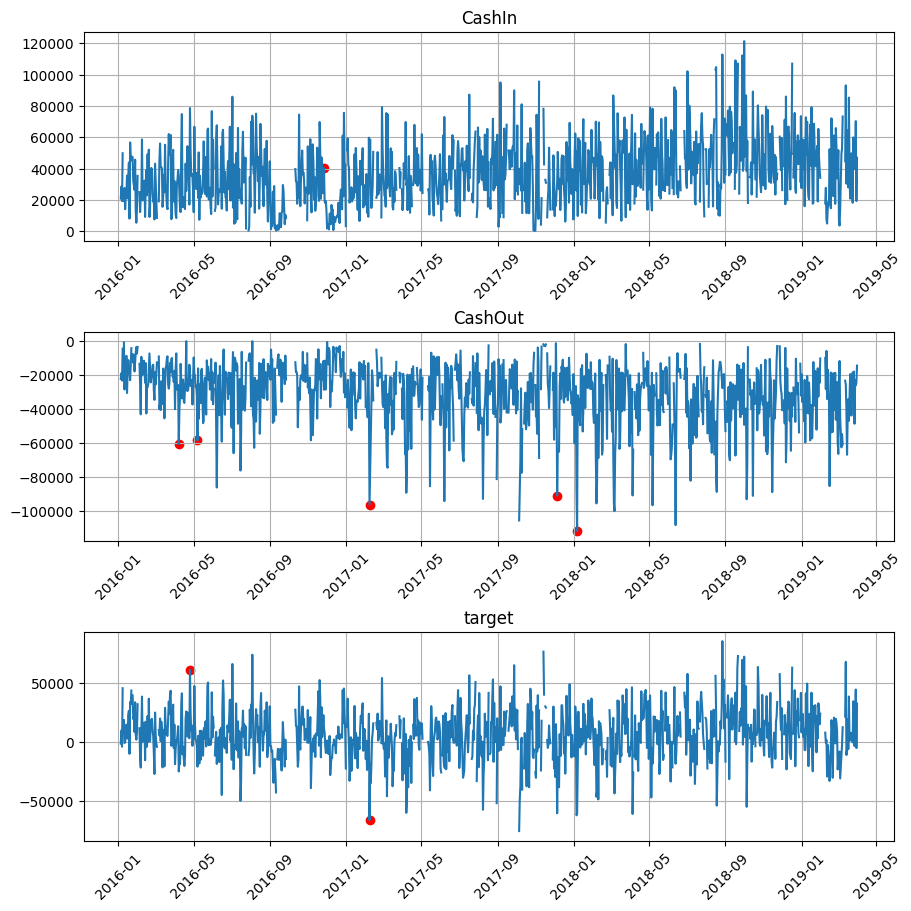

In [ ]:
from etna.analysis import (cross_corr_plot, distribution_plot, plot_anomalies,
                           plot_anomalies_interactive, plot_backtest,
                           plot_correlation_matrix, plot_forecast,
                           sample_acf_plot, sample_pacf_plot)

from etna.analysis.outliers import (get_anomalies_density, get_anomalies_hist,
                                    get_anomalies_median,
                                    get_anomalies_prediction_interval)

anomaly_dict = get_anomalies_median(ts, window_size=25)
plot_anomalies(ts, anomaly_dict, columns_num=1, figsize=(9, 3))
# слишком мало и неочевидный выбор выбросов

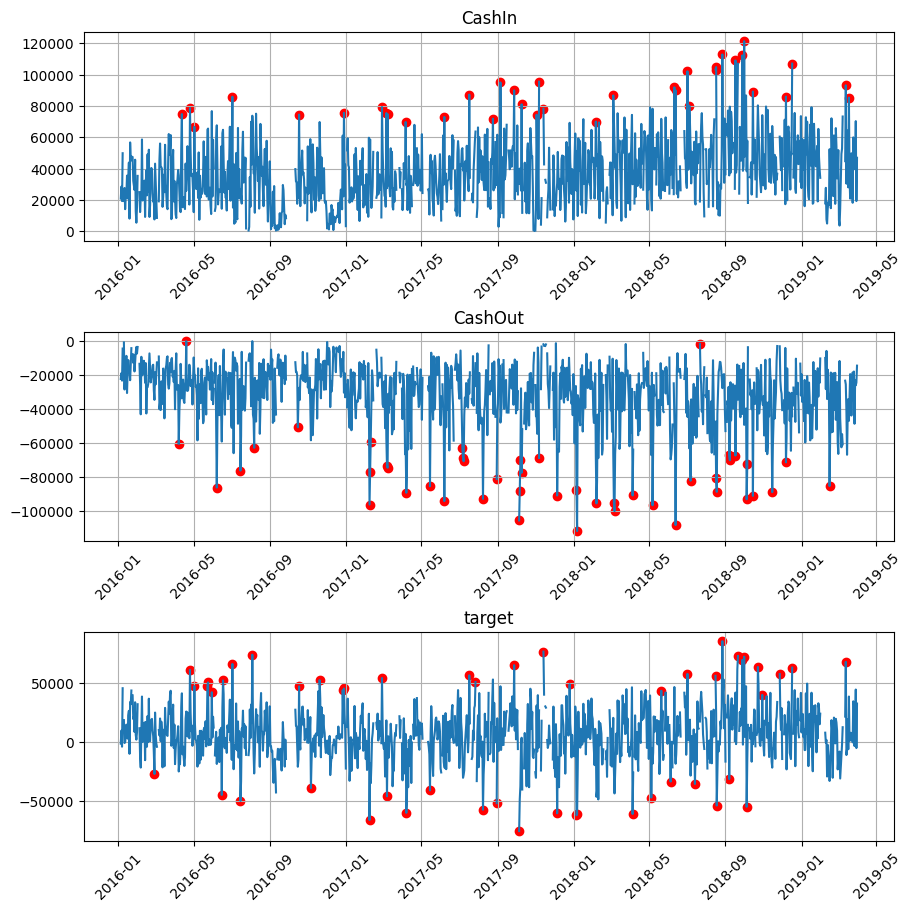

In [ ]:
anomaly_dict = get_anomalies_density(ts, window_size=18, distance_coef=1, n_neighbors=4)
plot_anomalies(ts, anomaly_dict, columns_num=1, figsize=(9, 3))
# слишком много аутлаеров, интуитивно кажется, что эти регулярные пики все-таки что-то значат

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


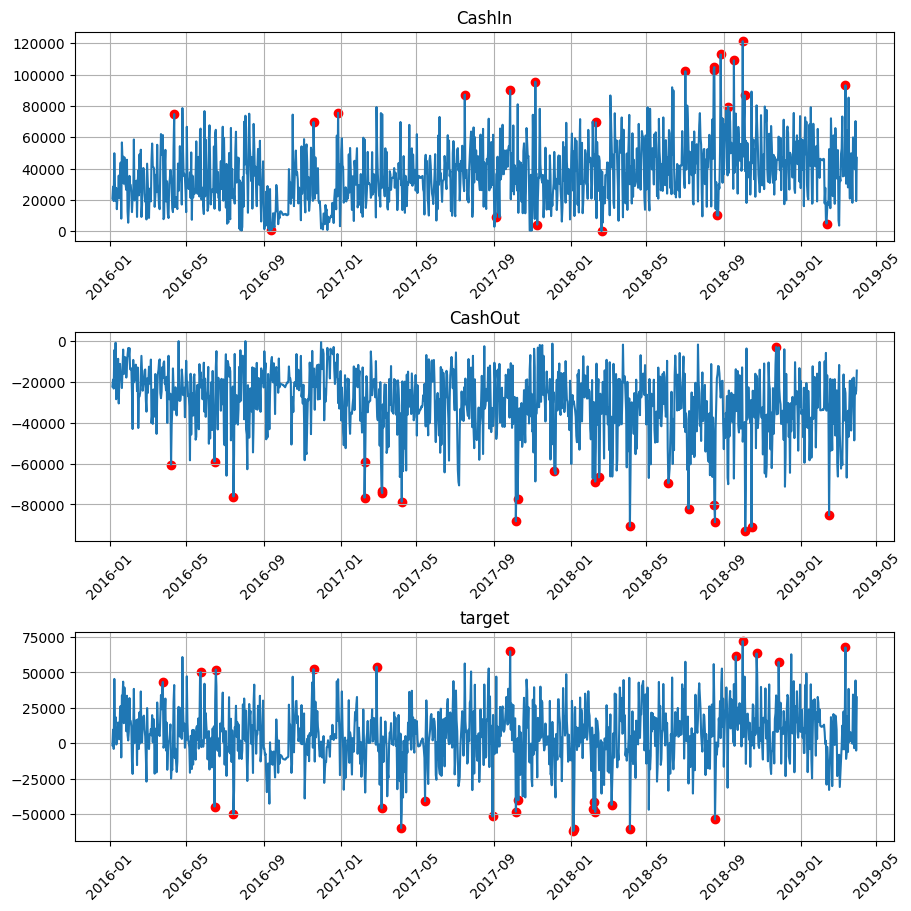

In [ ]:
from etna.models import ProphetModel
anomaly_dict = get_anomalies_prediction_interval(
    ts, model=ProphetModel, interval_width=0.99
)

plot_anomalies(ts, anomaly_dict, columns_num=1, figsize=(9, 3))
# кажется, в самый раз: не слишком много аномальных значений

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


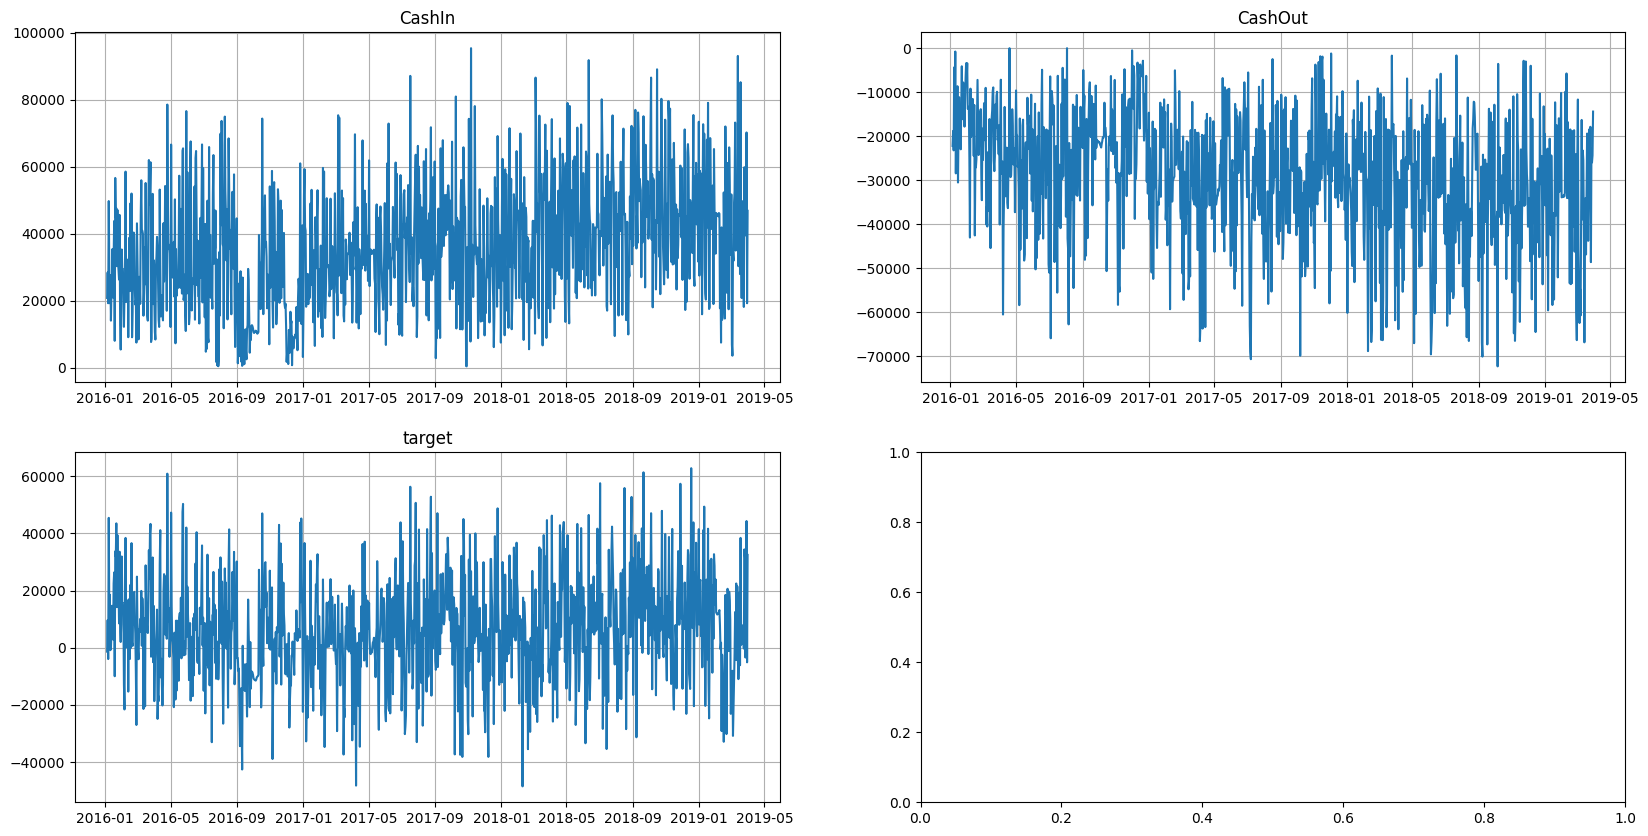

In [ ]:
from etna.transforms import PredictionIntervalOutliersTransform, TimeSeriesImputerTransform

# наиболее адекватный выбор аутлаеров на мой взгляд предлагает метод на основе предстказаний модели

outliers_remover = PredictionIntervalOutliersTransform(in_column="target", model=ProphetModel, interval_width=0.99)

outliers_imputer = TimeSeriesImputerTransform(
    in_column="target", strategy="running_mean", window=30
)
ts.fit_transform([outliers_remover, outliers_imputer])
ts.plot()
# теперь видим на графике, что пропущенных значений больше нет

### Задание 4. Построение мультисегментной модели (1.25 балла)

Постройте мульти-сегментную модель на основе Prophet, и оцените качество по SMAPE на кросс-валидации. В качестве горизонта предсказания возьмите 5 дней - этого же горизонта будем придерживаться и в дальнейшем.

Отрисуйте получившийся прогноз.

In [ ]:
from etna.pipeline import Pipeline
from etna.models import ProphetModel
from etna.metrics import SMAPE, MAE
from etna.analysis import plot_backtest

In [ ]:
HORIZON = 5

Исходя из статистики по каждому ряду, какой можно сделать вывод о том, как лучше предсказывать итоговое значение? Посчитайте то же самое исходя из MAE.

In [ ]:
import logging
logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.CRITICAL)


NFOLDS = 15
pipeline = Pipeline(model=ProphetModel(), horizon=HORIZON)
metrics, forecast, _ = pipeline.backtest(
    ts=ts, metrics=[SMAPE(), MAE()], n_folds=NFOLDS, aggregate_metrics=True
)
metrics

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.5s remaining:    0.0s
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   14.2s remaining:    0.0s
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with 

segment       SMAPE           MAE
0   CashIn   38.082447  14611.735150
1  CashOut   33.695292  10701.567218
2   target  119.446349  14093.828936

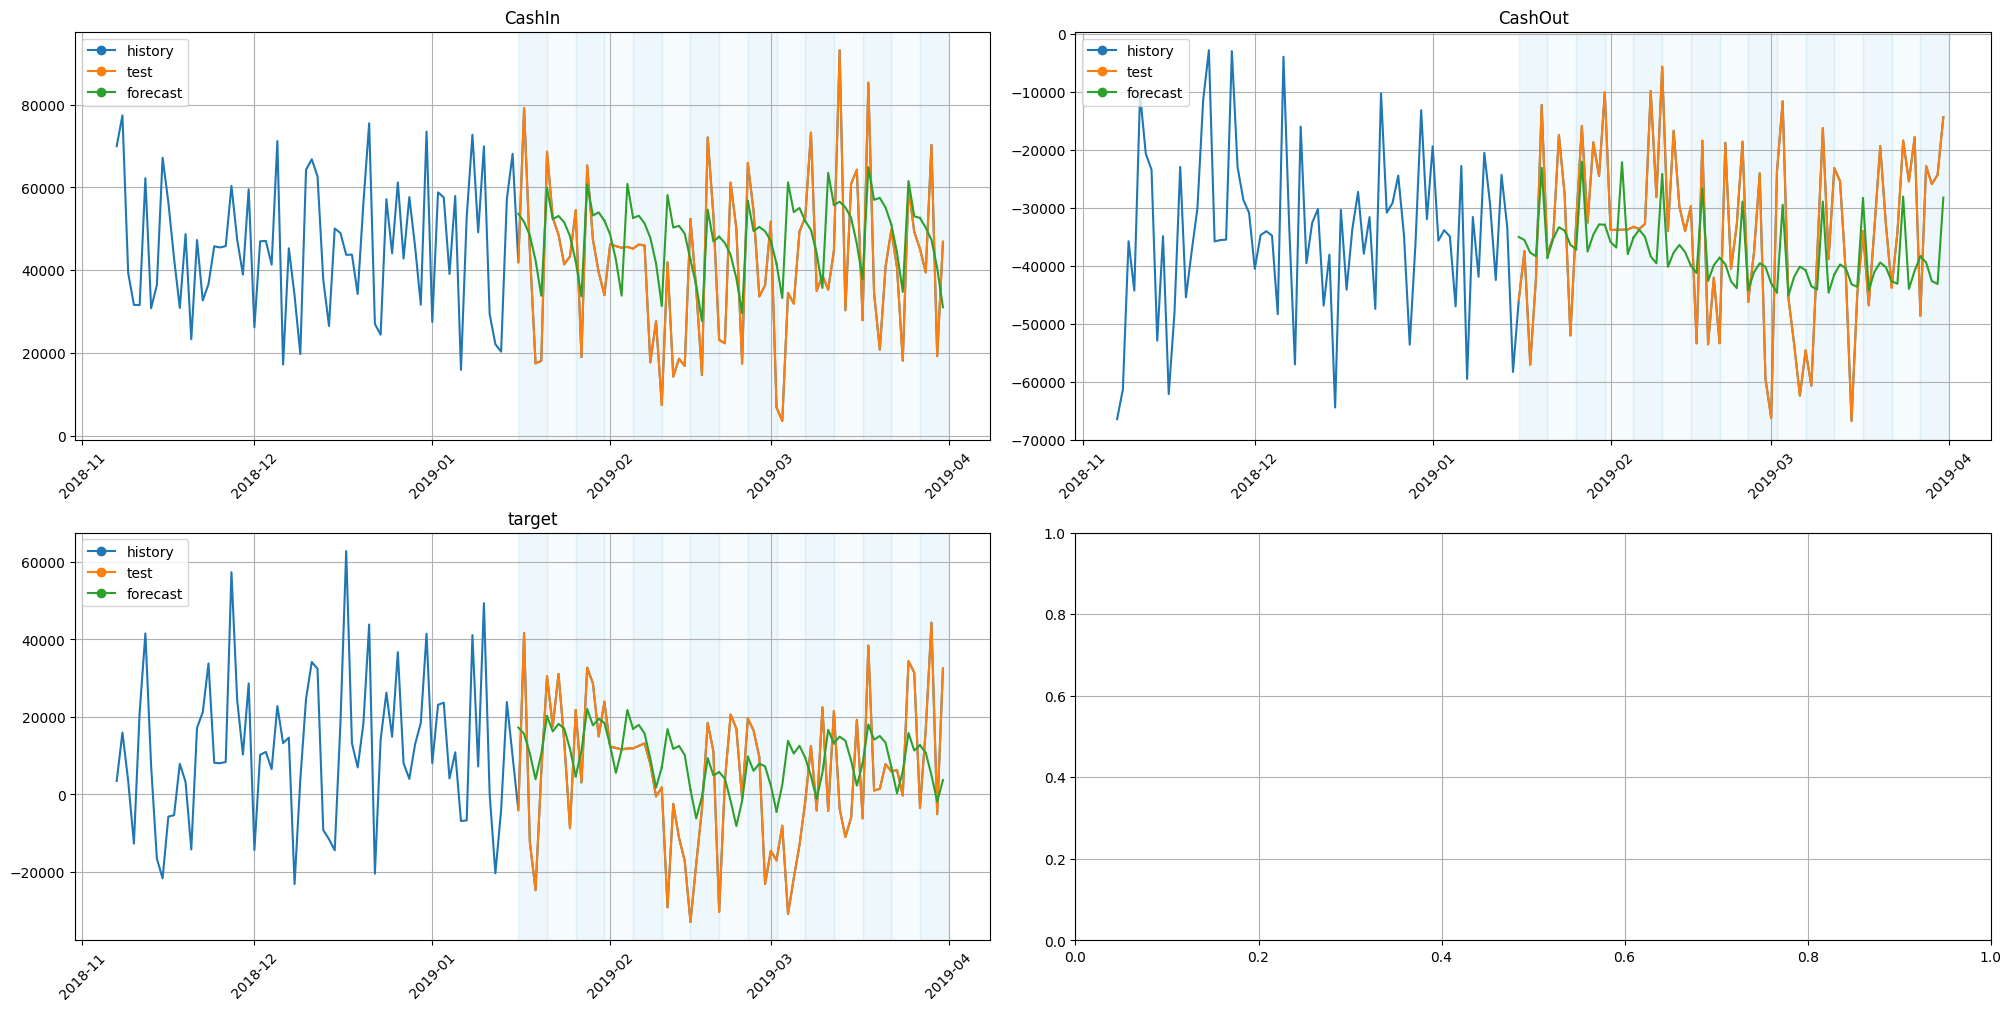

In [ ]:
plot_backtest(forecast, ts, history_len=70)

In [ ]:
# В общем мы видим, что модель лучше предсказывает значения CashIn и CashOut, чем таргет, который по сути является их суммой.
# Так что для получения прогноза нетто лучше складывать предсказания CashIn и CashOut. Причем это лучше видно именно по метрике SMAPE
#  (отличие на порядок), в МAE же это отличие не кажется таким значимым

### Задание 5. Иерархический временной ряд (2 балла)

Вопрос, поставленный в прошлом задании, тем не менее, естественным образом подводит нас к концепции **иерархического временного ряда** (когда один ряд состоит из других в качестве компонент). Это полезная концепция, которая может встретиться во многих задачах. В этом задании вам предстоит самостоятельно разобраться в деталях ее реализации в ETNA с использованием справочных материалов, предоставляемых библиотекой (как это часто бывает на практике). Они содержатся по следующей ссылке:

https://github.com/tinkoff-ai/etna/blob/master/examples/hierarchical_pipeline.ipynb

На выходе из первой части задания необходимо получить `TSDataset` с иерархической структурой, а также соответствующий реконсилятор, который позволит собирать искомый ряд из составных компонент. Классы, которые вам понадобятся, импортированы ниже.

In [ ]:
from etna.datasets import HierarchicalStructure
from etna.pipeline import HierarchicalPipeline
from etna.reconciliation import BottomUpReconciliator

In [ ]:
df_copy = df_copy.rename(columns={'Date':'timestamp'})
df_copy.set_index("timestamp", inplace=True)
df_copy

CashIn  CashOut   target
timestamp                           
1/5/2016   20840.0 -22200.0  -1360.0
1/6/2016   28460.0 -18810.0   9650.0
1/7/2016   19250.0 -23210.0  -3960.0
1/8/2016   49770.0  -4350.0  45420.0
1/9/2016       NaN      NaN      NaN
...            ...      ...      ...
3/27/2019  45160.0 -48600.0  -3440.0
3/28/2019  39480.0 -22840.0  16640.0
3/29/2019  70260.0 -25950.0  44310.0
3/30/2019  19250.0 -24350.0  -5100.0
3/31/2019  46870.0 -14400.0  32470.0

[1182 rows x 3 columns]

In [ ]:
segments = ['CashIn', 'CashOut']
periods = len(df_copy)

hierarchical_df = []
for segment_name in segments:
    segment = df_copy[segment_name]

    segment_slice = pd.DataFrame(
        {"timestamp": segment.index, "target": segment.values, "segment": [segment_name] * periods}
    )
    hierarchical_df.append(segment_slice)

hierarchical_df = pd.concat(hierarchical_df, axis=0)

hierarchical_df

timestamp   target  segment
0      1/5/2016  20840.0   CashIn
1      1/6/2016  28460.0   CashIn
2      1/7/2016  19250.0   CashIn
3      1/8/2016  49770.0   CashIn
4      1/9/2016      NaN   CashIn
...         ...      ...      ...
1177  3/27/2019 -48600.0  CashOut
1178  3/28/2019 -22840.0  CashOut
1179  3/29/2019 -25950.0  CashOut
1180  3/30/2019 -24350.0  CashOut
1181  3/31/2019 -14400.0  CashOut

[2364 rows x 3 columns]

In [ ]:
hierarchical_df = TSDataset.to_dataset(df=hierarchical_df)

In [ ]:
hierarchical_structure = HierarchicalStructure(
    level_structure={"net": ["CashIn", "CashOut"]}, level_names=["total", "action"]
)

hierarchical_structure

HierarchicalStructure(level_structure = {'net': ['CashIn', 'CashOut']}, level_names = ['total', 'action'], )

In [ ]:
hierarchical_ts = TSDataset(df=hierarchical_df, freq="D", hierarchical_structure=hierarchical_structure)

hierarchical_ts

segment      CashIn  CashOut
feature      target   target
timestamp                   
2016-01-05  20840.0 -22200.0
2016-01-06  28460.0 -18810.0
2016-01-07  19250.0 -23210.0
2016-01-08  49770.0  -4350.0
2016-01-09      NaN      NaN
...             ...      ...
2019-03-27  45160.0 -48600.0
2019-03-28  39480.0 -22840.0
2019-03-29  70260.0 -25950.0
2019-03-30  19250.0 -24350.0
2019-03-31  46870.0 -14400.0

[1182 rows x 2 columns]

In [ ]:
reconciliator = BottomUpReconciliator(target_level="total", source_level="action")
reconciliator.fit(ts=hierarchical_ts)
reconciliator.mapping_matrix.toarray()

array([[1, 1]], dtype=int32)

In [ ]:
reconciliator.aggregate(ts=hierarchical_ts)

segment      CashIn  CashOut
feature      target   target
timestamp                   
2016-01-05  20840.0 -22200.0
2016-01-06  28460.0 -18810.0
2016-01-07  19250.0 -23210.0
2016-01-08  49770.0  -4350.0
2016-01-09      NaN      NaN
...             ...      ...
2019-03-27  45160.0 -48600.0
2019-03-28  39480.0 -22840.0
2019-03-29  70260.0 -25950.0
2019-03-30  19250.0 -24350.0
2019-03-31  46870.0 -14400.0

[1182 rows x 2 columns]

In [ ]:
hierarchical_ts

segment      CashIn  CashOut
feature      target   target
timestamp                   
2016-01-05  20840.0 -22200.0
2016-01-06  28460.0 -18810.0
2016-01-07  19250.0 -23210.0
2016-01-08  49770.0  -4350.0
2016-01-09      NaN      NaN
...             ...      ...
2019-03-27  45160.0 -48600.0
2019-03-28  39480.0 -22840.0
2019-03-29  70260.0 -25950.0
2019-03-30  19250.0 -24350.0
2019-03-31  46870.0 -14400.0

[1182 rows x 2 columns]

Во второй части задания примените найденные на предыдущих этапах преобразования очистку от аутлаеров уже к иерархическому датасету, и запустите на нем Prophet с MAE на кросс-валидации.

In [ ]:
hierarchical_pipeline = HierarchicalPipeline(
    transforms=[
        PredictionIntervalOutliersTransform(in_column="target", model=ProphetModel, interval_width=0.99),
        TimeSeriesImputerTransform(in_column="target", strategy="running_mean", window=30),
    ],
    model=ProphetModel(),
    reconciliator=reconciliator,
)

hierarchical_metrics, hierarchical_forecast, _ = hierarchical_pipeline.backtest(
    ts=hierarchical_ts, metrics=[SMAPE(), MAE()], n_folds=NFOLDS, aggregate_metrics=True
)
hierarchical_metrics
# обе метрики стали хуже

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   20.7s remaining:    0.0s
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[Parallel(n_jobs=1)]: Done   2 out of  

segment       SMAPE           MAE
0     net  125.339126  14589.436035

### Задание 6. Построение признаков (1.5 балла)

Вернемся к нашему исходному мультисегментному ряду - теперь поработаем с моделями, которые требуют построения признаков - `ARIMA` и `CatBoost`. Построим для них признаки, и попробуем при помощи них добиться улучшения качества. Из обязательного: 1) постройте графики автокорреляции и при помощи них обоснуйте выбор лаговых признаков 2) для катбуста включите в признаки результаты STL разложения. Кроме этого, подумайте на экспертном уровне, какие закономерности могут присутствовать в пополнени наличности из банкомата? Снятии? Что из этого кажется более предсказуемым, и почему? Cделайте соответствующие признаки, и снабдите их кратким комментарием.

После этого, обучите на получившихся признаках модели.

Ниже приведены импорты, которые вам точно понадобятся - к ним необходимо добавить те инструменты, которые вы дополнительно решите использовать в анализе.

In [ ]:
from etna.analysis import sample_acf_plot, sample_pacf_plot, stl_plot
from etna.ensembles import DirectEnsemble, StackingEnsemble, VotingEnsemble
from etna.models import (CatBoostMultiSegmentModel, CatBoostModelPerSegment,
                         AutoARIMAModel)
from etna.transforms import STLTransform, LagTransform, SegmentEncoderTransform

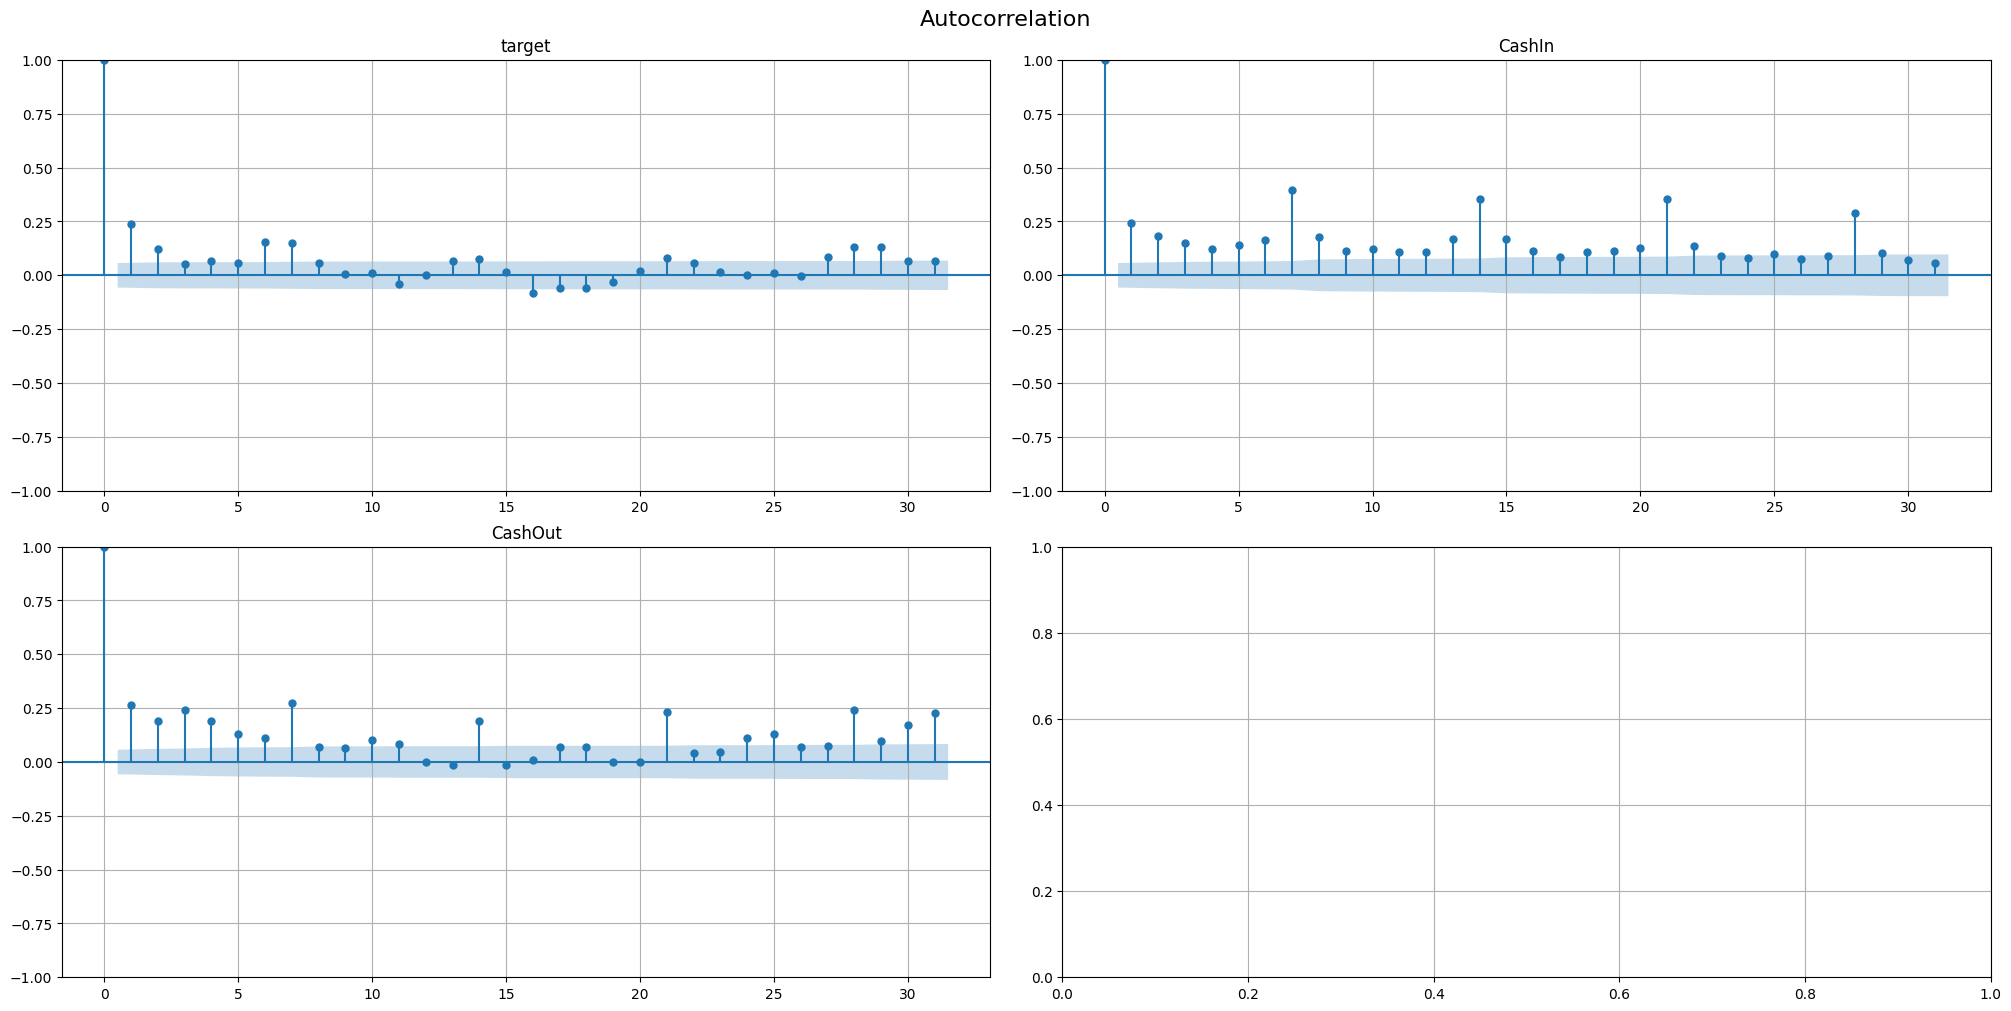

In [ ]:
# Графики автокорреляции
sample_acf_plot(ts, lags=31)

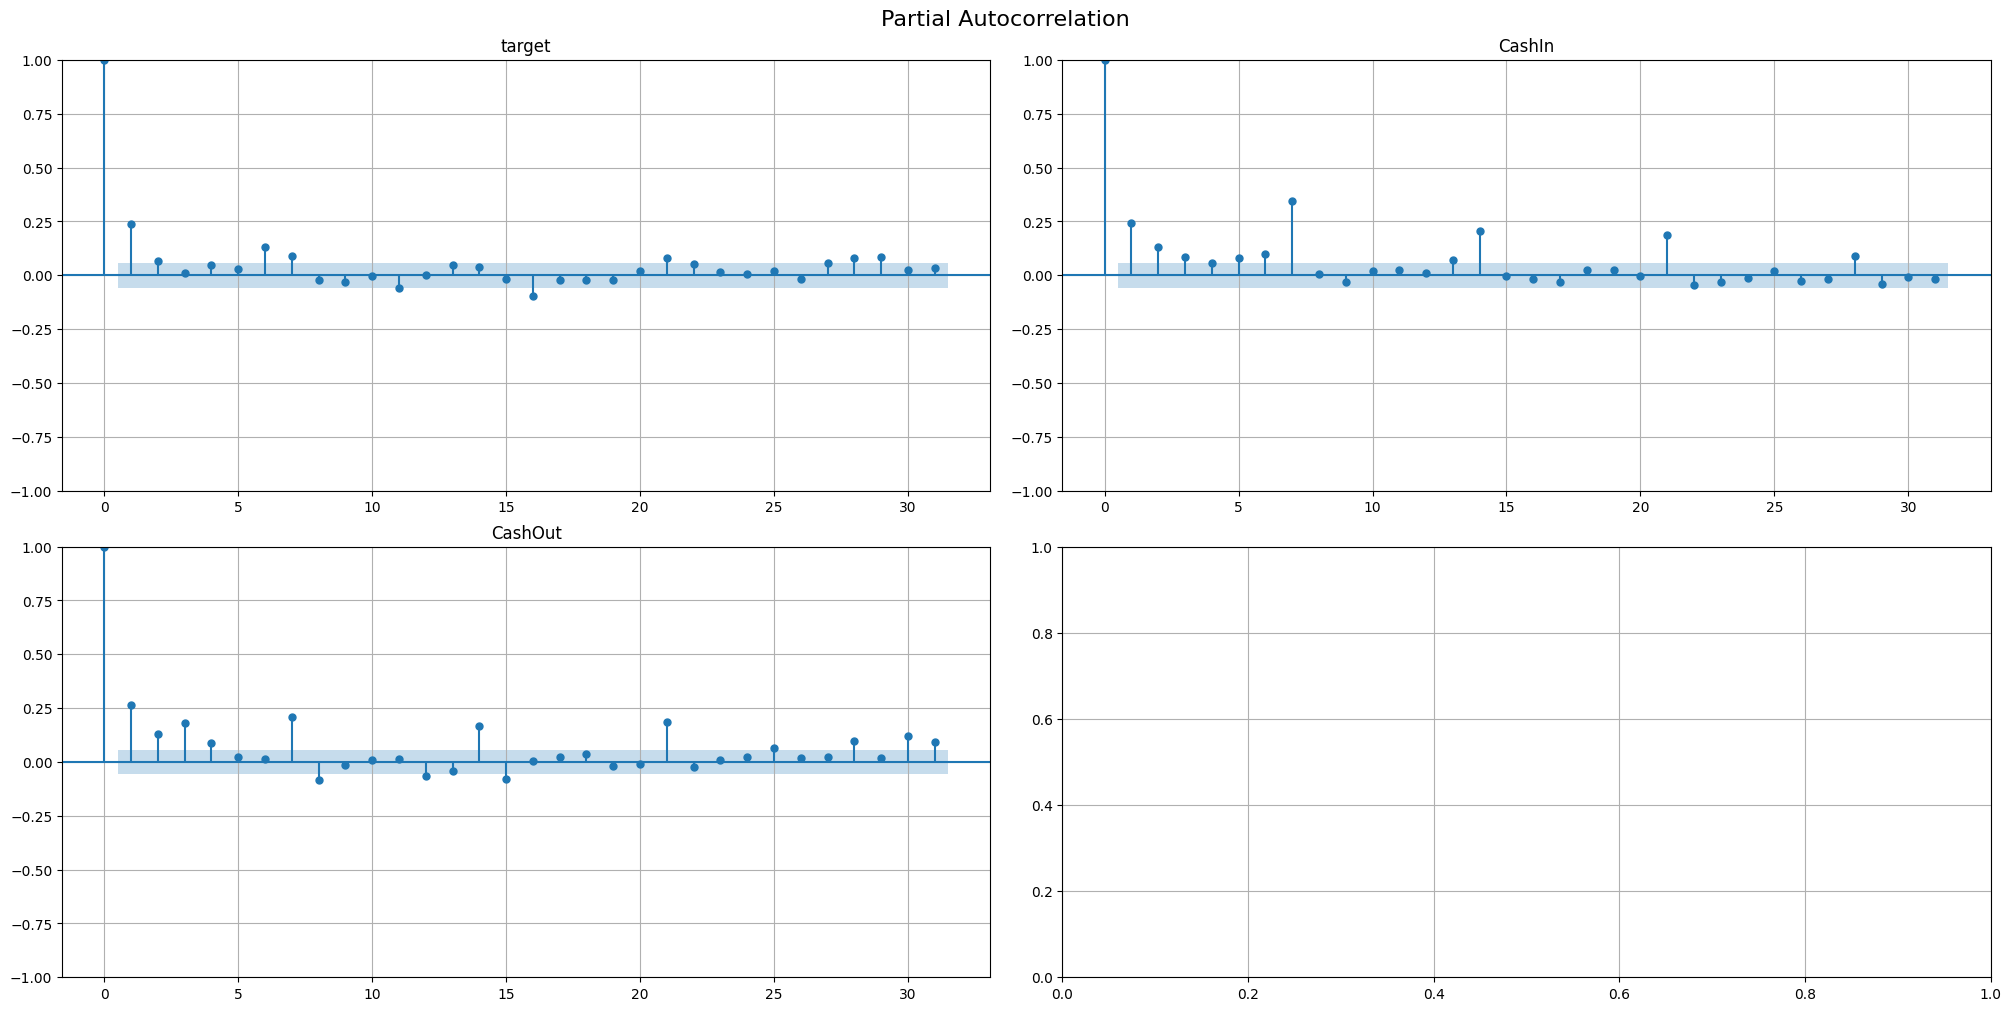

In [ ]:
sample_pacf_plot(ts, lags=31)

In [ ]:
# Исходя из графиков автокорреляции и частичной автокорреляции можем выделить следующие лаги:
# * с периодичностью в 7 дней: 7, 14, 21, 28
# * первые несколько дней месяца: 1, 2, 3, 4, 5, 6
# * последний несколько дней месяца: 30, 31
# В целом это можно объяснить днями, когда надо оплачивать за аренду квартиры (и снимать наличность)
# Также есть дни прихода аванса и зарплаты

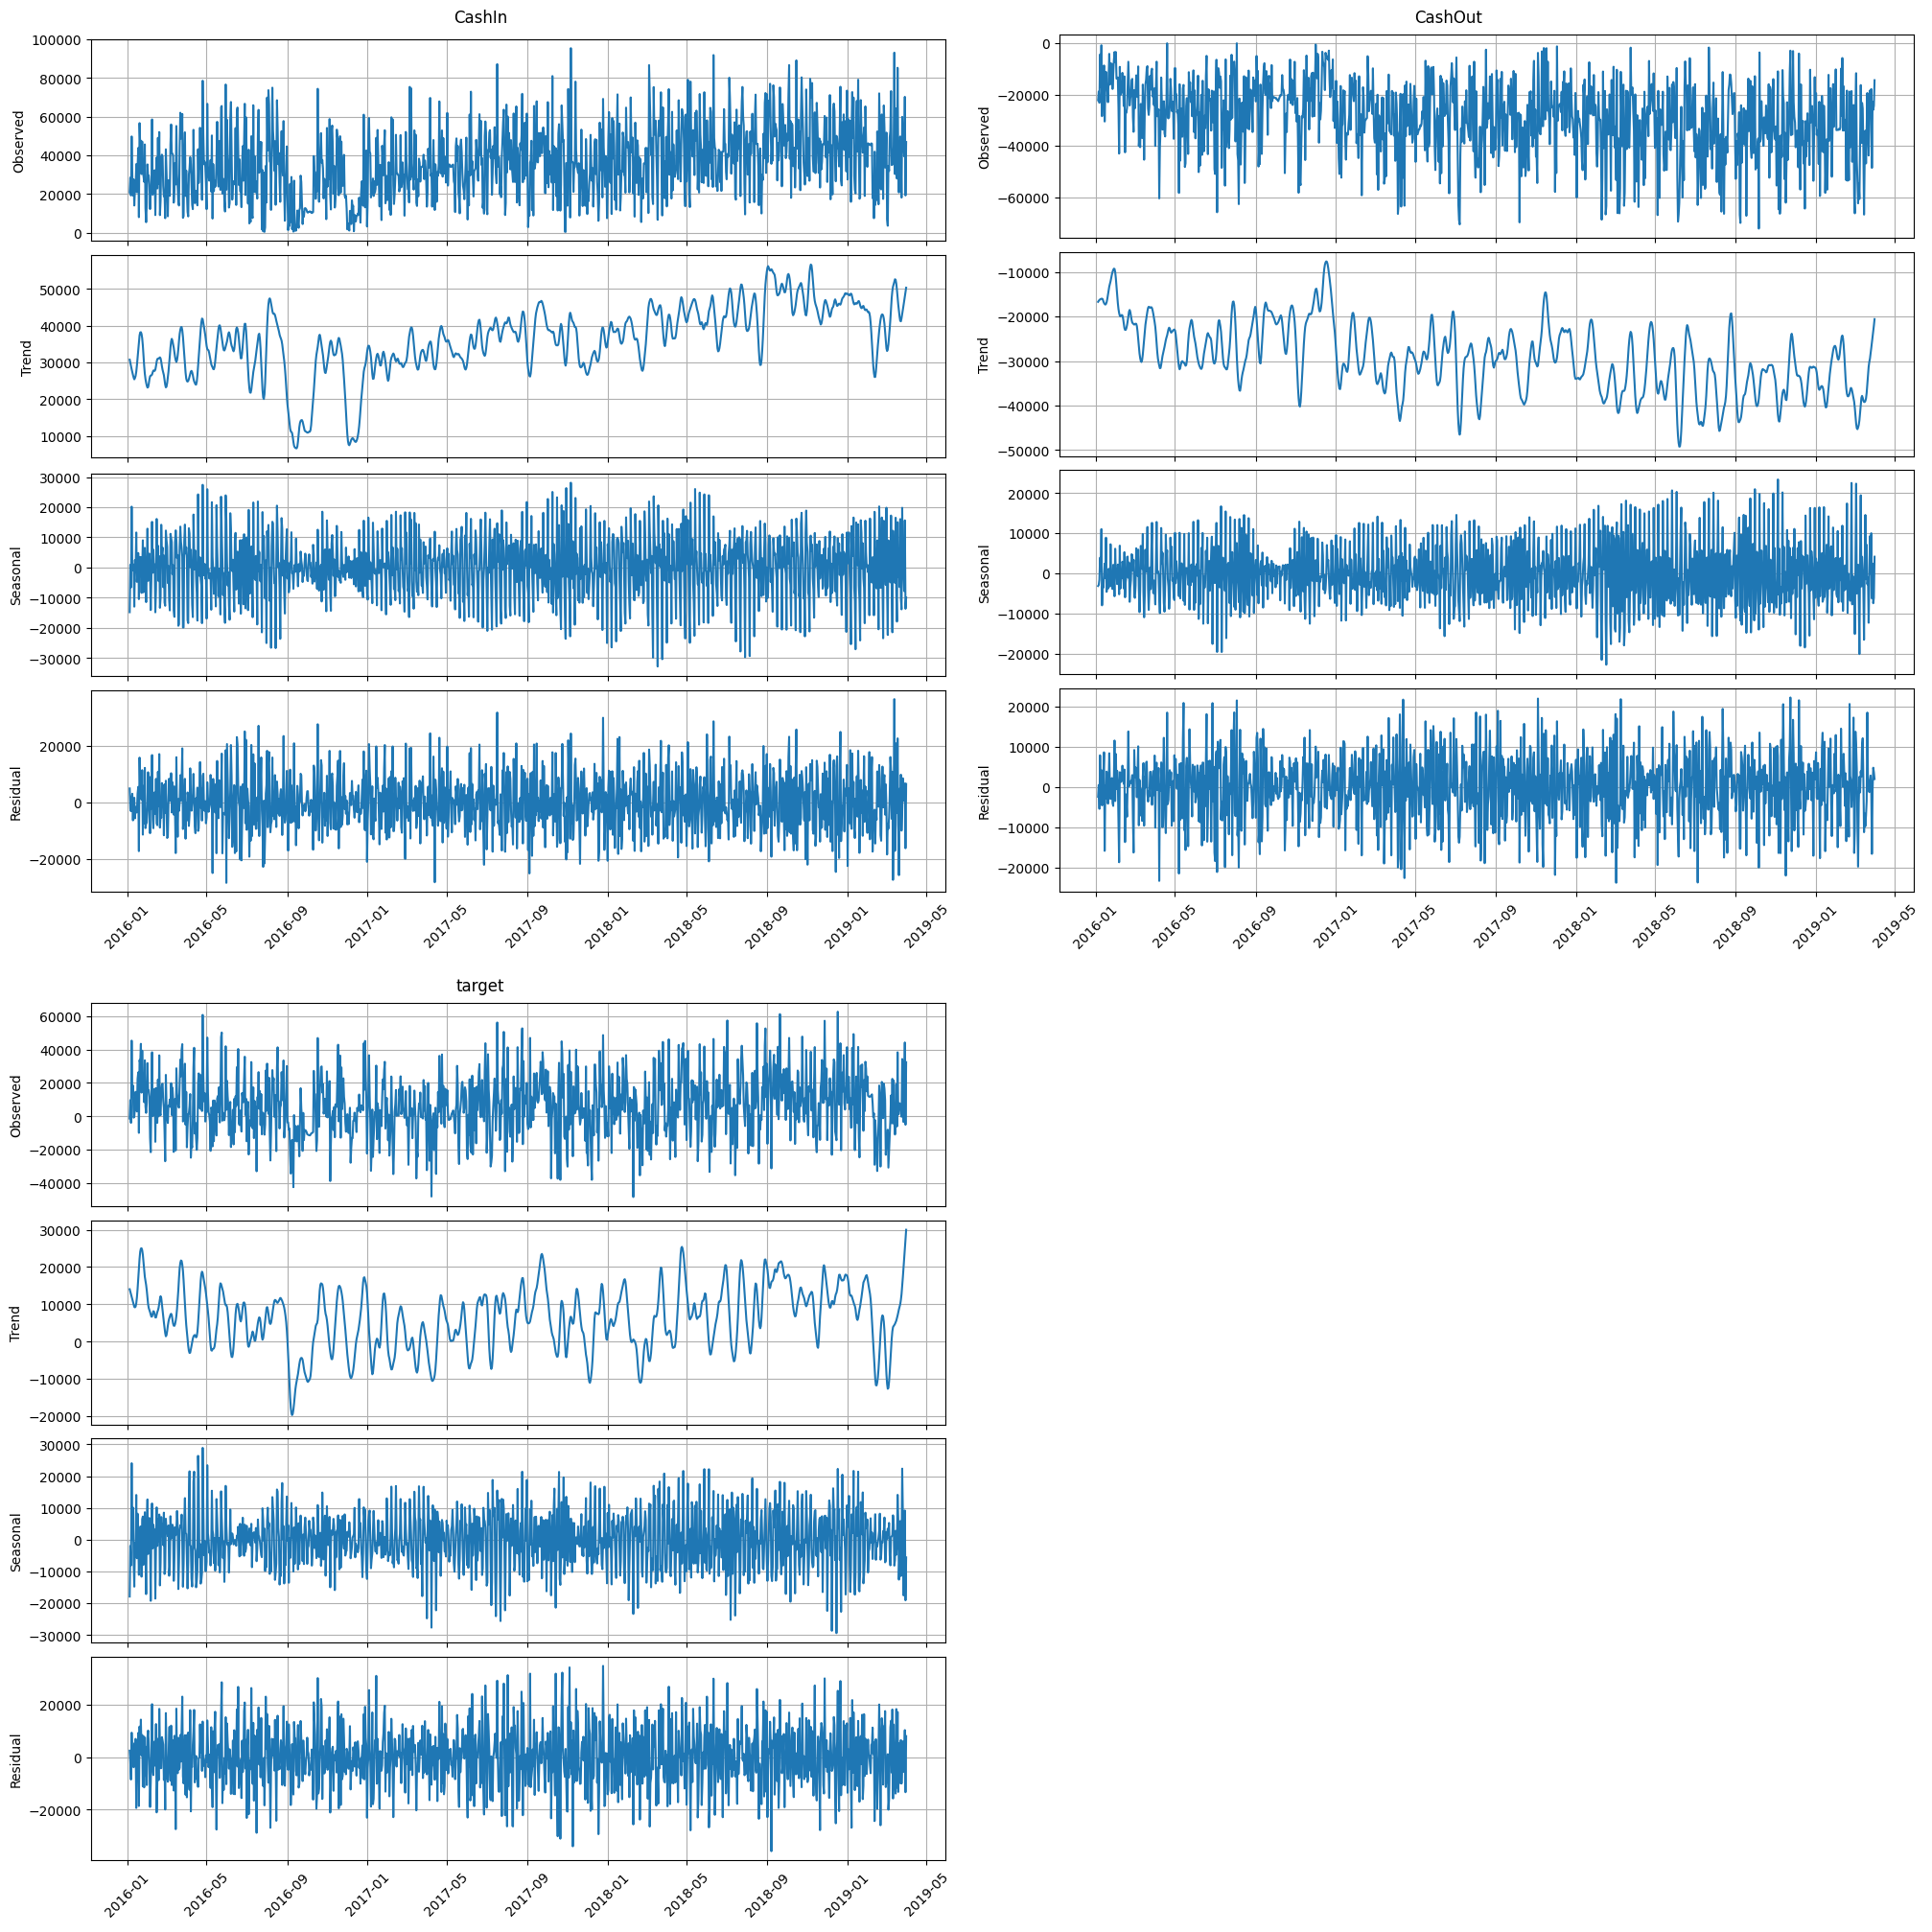

In [ ]:
# STL
stl_plot(ts=ts, period=7)

In [ ]:
from etna.transforms import SpecialDaysTransform, LinearTrendTransform
NFOLDS = 15
cb_ms_pipeline = Pipeline(model=CatBoostMultiSegmentModel(),
                          transforms=[STLTransform(in_column="target", period=7),
                                      LagTransform(in_column="target", lags=[1, 2, 3, 4, 5, 6, 7, 14, 21, 28, 30, 31]),
                                      SpecialDaysTransform(),
                                      LinearTrendTransform(in_column="target"),
                                      SegmentEncoderTransform()],
                          horizon=HORIZON)

cb_ms_metrics, cb_ms_forecast, _ = cb_ms_pipeline.backtest(
    ts=ts, metrics=[SMAPE(), MAE()], n_folds=NFOLDS, aggregate_metrics=True
)
cb_ms_metrics
# обе метрики хуже чем на Prophet, и чем на иерархическом датасете

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   17.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   28.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   34.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   43.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   52.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   58.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  2.2min finished


segment       SMAPE           MAE
0   CashIn   51.548401  22408.173447
1  CashOut   78.412412  19199.412027
2   target  127.653349  21585.401032

In [ ]:
cb_mps_pipeline = Pipeline(model=CatBoostModelPerSegment(),
                          transforms=[STLTransform(in_column="target", period=7),
                                      LagTransform(in_column="target", lags=[1, 2, 3, 4, 5, 6, 7, 14, 21, 28, 30, 31]),
                                      SpecialDaysTransform(),
                                      LinearTrendTransform(in_column="target"),
                                      SegmentEncoderTransform()],
                          horizon=HORIZON)

cb_mps_metrics, cb_mps_forecast, _ = cb_mps_pipeline.backtest(
    ts=ts, metrics=[SMAPE(), MAE()], n_folds=NFOLDS, aggregate_metrics=True
)
cb_mps_metrics
# SMAPE лучше чем на иерархическом датасете и прошлой модели, но хуже чем на первой (Prophet). MAE хуже всех, кроме предыдущей

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   16.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   33.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   47.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  1.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  2.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  2.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  2.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  3.9min finished


segment       SMAPE           MAE
0   CashIn   48.433480  20060.561514
1  CashOut   58.270067  15689.740279
2   target  123.046020  19534.336365

In [ ]:
NFOLDS = 4 # падала при большем числе фолдов
arima_pipeline = Pipeline(model=AutoARIMAModel(),
                          transforms=[STLTransform(in_column="target", period=7),
                                      LagTransform(in_column="target", lags=[28]),
                                      SegmentEncoderTransform()],
                          horizon=HORIZON)

arima_metrics, arima_forecast, _ = arima_pipeline.backtest(
    ts=ts, metrics=[SMAPE(), MAE()], n_folds=NFOLDS, aggregate_metrics=True
)
arima_metrics
# SMAPE худшая из всех, MAE уступает только первым двум моделям (Prophet и иерархическая)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   31.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  2.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  2.6min finished


segment       SMAPE           MAE
0   CashIn   39.731895  19447.667138
1  CashOut   39.908732  13370.164351
2   target  140.180747  16013.528607

### Задание 7. Стратегии прогнозирования (1.25 балла)

Как нам известно по семинарским занятиям, при построении прогноза на горизонте дальше следующего наблюдения перед нами встает задача определиться со стратегией генерации прогноза. Попробуйте разные стратегии на нашем горизонте из 5 дней (прямая, рекурсивная, смешанная dirrec). Какая стратегия в совокупности с какой моделью дает лучший результат?

Учитывайте особенности, которые некоторые стратегии могут накладывать на признаки (в частности, на лаговые переменные).

При необходимости, в смешанном методе пользуйтесь упрощенной схемой спецификации моделей/преобразований.

In [ ]:
from etna.pipeline import AutoRegressivePipeline, Pipeline, assemble_pipelines
from etna.ensembles import DirectEnsemble

In [ ]:
# Прямую стратегию мы уже пробовали в моделях выше, попробуем рекурсивную с катбусом и профет

In [ ]:
# Рекурсивная
NFOLDS = 15
autoregressivepipeline = AutoRegressivePipeline(
    model=CatBoostModelPerSegment(), transforms=[STLTransform(in_column="target", period=7),
                                      LagTransform(in_column="target", lags=[1, 2, 3, 4, 5, 6, 7, 14, 21, 28, 30, 31]),
                                      SpecialDaysTransform(),
                                      LinearTrendTransform(in_column="target"),
                                      SegmentEncoderTransform()],
    horizon=HORIZON, step=1
)
ar_cb_mps_metrics, ar_cb_mps_forecast, _ = autoregressivepipeline.backtest(
    ts=ts, metrics=[SMAPE(), MAE()], n_folds=NFOLDS, aggregate_metrics=True
)
ar_cb_mps_metrics
# метрики стали хуже, чем в прямой модели

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   18.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   37.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   55.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  2.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  2.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  2.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  3.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  4.5min finished


segment       SMAPE           MAE
0   CashIn   48.263253  17480.978246
1  CashOut   41.914804  13342.244955
2   target  138.231182  16983.572120

In [ ]:
autoregressivepipeline_prophet = AutoRegressivePipeline(
    model=ProphetModel(),
    horizon=HORIZON, step=1
)
ar_pm_metrics, ar_pm_forecast, _ = autoregressivepipeline_prophet.backtest(
    ts=ts, metrics=[SMAPE(), MAE()], n_folds=NFOLDS, aggregate_metrics=True
)
ar_pm_metrics
# метрики не поменялись

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   28.1s remaining:    0.0s
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   55.4s remaining:    0.0s
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with 

segment       SMAPE           MAE
0   CashIn   38.082447  14611.735150
1  CashOut   33.695292  10701.567218
2   target  119.446349  14093.828936

In [ ]:
# директ решила попробовать с лучшим катбустом
models = [CatBoostModelPerSegment(), CatBoostModelPerSegment()]
horizons = [5, 10]
NUMBER_OF_LAGS = 20
transforms = [
    LinearTrendTransform(in_column="target"),
    STLTransform(in_column="target", period=7),
     SpecialDaysTransform(),
     LinearTrendTransform(in_column="target"),
     SegmentEncoderTransform(),

    [
        LagTransform(
            in_column="target",
            lags=[i for i in range(horizons[0], horizons[0] + NUMBER_OF_LAGS)],
            out_column="target_lag",
        ),
        LagTransform(
            in_column="target",
            lags=[i for i in range(horizons[1], horizons[1] + NUMBER_OF_LAGS)],
            out_column="target_lag",
        ),

    ],
]

direct_pipelines = assemble_pipelines(models=models, transforms=transforms, horizons=horizons)

direct_ensemble = DirectEnsemble(pipelines=direct_pipelines)

cb_ens_metrics, cb_ens_forecast, _ = direct_ensemble.backtest(
    ts=ts, metrics=[SMAPE(), MAE()], n_folds=NFOLDS, aggregate_metrics=True
)
cb_ens_metrics
# по SMAPE получилась модель, уступающая только Prophet (хотя MAE хуже, чем у иерархической)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   22.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   45.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   45.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   47.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   24.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   4

segment       SMAPE           MAE
0   CashIn   41.640551  17584.632507
1  CashOut   46.394537  14618.062225
2   target  121.584549  18325.877243

### Задание 8. Ансамбли (1.25 балла)

Чтобы не выбирать лучшую модель, мы можем использовать преимущества каждой - давайте объединим все наши наработки в ансамбль. Попробуйте различные опции ансамблирования, и выберите ту, которая работает лучше всего (не забывайте, что внутри каждого ансамбля у нас тоже есть параметры, которые мы можем варьировать - веса в voting, включаемые признаки в stacking).

In [ ]:
from etna.ensembles import StackingEnsemble, VotingEnsemble

In [ ]:
pipelines = [cb_mps_pipeline, pipeline] #- 2 лучших пайплайна
# не можем использовать direct_ensemble, т.к. нужен одинаковый горизонт у моделей, а там мы юзаем 2 горизонта

In [ ]:
voting_ensemble1 = VotingEnsemble(pipelines=pipelines)
voting_ensemble1_metrics, voting_ensemble1_forecast, _ = voting_ensemble1.backtest(
    ts=ts, metrics=[SMAPE(), MAE()], n_folds=NFOLDS, aggregate_metrics=True
)
voting_ensemble1_metrics
# MAE стала хуже, чем у чистого Prophet, а вот SMAPE лучше на 0.1

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   20.3s remaining:    0.0s
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   21.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   21.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.8s finish

segment       SMAPE           MAE
0   CashIn   40.614323  16220.661329
1  CashOut   35.651783  11223.403752
2   target  119.332680  15367.824013

In [ ]:
# попробуем неравные веса

voting_ensemble2 = VotingEnsemble(pipelines=pipelines, weights=[1, 2])
voting_ensemble2_metrics, voting_ensemble2_forecast, _ = voting_ensemble2.backtest(
    ts=ts, metrics=[SMAPE(), MAE()], n_folds=NFOLDS, aggregate_metrics=True
)
voting_ensemble2_metrics
# метрики стали немного лучше, МАЕ почти догнала минимум по моделям

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.2s remaining:    0.0s
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   15.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   15.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.3s finish

segment       SMAPE           MAE
0   CashIn   39.273709  15360.784829
1  CashOut   33.336605  10576.326288
2   target  119.269188  14645.975882

In [ ]:
# поменяем веса местами
voting_ensemble3 = VotingEnsemble(pipelines=pipelines, weights=[2, 1])
voting_ensemble3_metrics, voting_ensemble3_forecast, _ = voting_ensemble3.backtest(
    ts=ts, metrics=[SMAPE(), MAE()], n_folds=NFOLDS, aggregate_metrics=True
)
voting_ensemble3_metrics
# хуже, так что сохраним соотношение, где вес второй модели больше

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.7s remaining:    0.0s
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   16.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   16.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.8s finish

segment       SMAPE           MAE
0   CashIn   42.940230  17452.722315
1  CashOut   39.988096  12277.400560
2   target  120.601229  16412.896396

In [ ]:
voting_ensemble4 = VotingEnsemble(pipelines=pipelines, weights=[4, 1])
voting_ensemble4_metrics, voting_ensemble4_forecast, _ = voting_ensemble4.backtest(
    ts=ts, metrics=[SMAPE(), MAE()], n_folds=NFOLDS, aggregate_metrics=True
)
voting_ensemble4_metrics
# минимальный SMAPE получили, МАЕ похуже

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.9s remaining:    0.0s
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   16.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   16.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.9s finish

segment       SMAPE           MAE
0   CashIn   45.036757  18486.358872
1  CashOut   45.645266  13444.004501
2   target  118.993438  17447.186047

In [ ]:
# таким образом, лучшее качество показал ансамбль из Prophet и CatBoostModelPerSegment, c весами: 4 и 1

In [ ]:
metrics_list = [metrics, hierarchical_metrics, cb_ms_metrics, cb_mps_metrics, arima_metrics,
           ar_cb_mps_metrics, ar_pm_metrics, cb_ens_metrics, voting_ensemble1_metrics, voting_ensemble2_metrics, voting_ensemble3_metrics, voting_ensemble4_metrics]
metrics_df = pd.concat(metrics_list, keys=['Prophet', 'HierarchicalPipeline', 'CatBoostMultiSegmentModel', 'CatBoostModelPerSegment', 'AutoARIMAModel',
           'AutoRegressive_CatBoostModelPerSegment', 'AutoRegressive_Prophet', 'CatBoostModelPerSegment_Ensemble', 'Voting_ensemble_CatBoostModelPerSegment_Prophet',
           'Voting_ensemble_CatBoostModelPerSegment_Prophet (1, 2)', 'Voting_ensemble_CatBoostModelPerSegment_Prophet (2, 1)', 'Voting_ensemble_CatBoostModelPerSegment_Prophet (1, 4)'])
metrics_df

segment       SMAPE  \
Prophet                                            0   CashIn   38.082447   
                                                   1  CashOut   33.695292   
                                                   2   target  119.446349   
HierarchicalPipeline                               0      net  125.339126   
CatBoostMultiSegmentModel                          0   CashIn   51.548401   
                                                   1  CashOut   78.412412   
                                                   2   target  127.653349   
CatBoostModelPerSegment                            0   CashIn   48.433480   
                                                   1  CashOut   58.270067   
                                                   2   target  123.046020   
AutoARIMAModel                                     0   CashIn   39.731895   
                                                   1  CashOut   39.908732   
                                                   2   target  140.180747   
AutoRegressive_CatBoostModelPerSegment             0   CashIn   48.263253   
                                                   1  CashOut   41.914804   
                                                   2   target  138.231182   
AutoRegressive_Prophet                             0   CashIn   38.082447   
                                                   1  CashOut   33.695292   
                                                   2   target  119.446349   
CatBoostModelPerSegment_Ensemble                   0   CashIn   41.640551   
                                                   1  CashOut   46.394537   
                                                   2   target  121.584549   
Voting_ensemble_CatBoostModelPerSegment_Prophet    0   CashIn   40.614323   
                                                   1  CashOut   35.651783   
                                                   2   target  119.332680   
Voting_ensemble_CatBoostModelPerSegment_Prophet... 0   CashIn   39.273709   
                                                   1  CashOut   33.336605   
                                                   2   target  119.269188   
Voting_ensemble_CatBoostModelPerSegment_Prophet... 0   CashIn   42.940230   
                                                   1  CashOut   39.988096   
                                                   2   target  120.601229   
Voting_ensemble_CatBoostModelPerSegment_Prophet... 0   CashIn   45.036757   
                                                   1  CashOut   45.645266   
                                                   2   target  118.993438   

                                                               MAE  
Prophet                                            0  14611.735150  
                                                   1  10701.567218  
                                                   2  14093.828936  
HierarchicalPipeline                               0  14589.436035  
CatBoostMultiSegmentModel                          0  22408.173447  
                                                   1  19199.412027  
                                                   2  21585.401032  
CatBoostModelPerSegment                            0  20060.561514  
                                                   1  15689.740279  
                                                   2  19534.336365  
AutoARIMAModel                                     0  19447.667138  
                                                   1  13370.164351  
                                                   2  16013.528607  
AutoRegressive_CatBoostModelPerSegment             0  17480.978246  
                                                   1  13342.244955  
                                                   2  16983.572120  
AutoRegressive_Prophet                             0  14611.735150  
                                                   1  10701.567218  
                                               